## One Day Analysis

This is a sketch of how to do a single day analysis using pyspark mainly based on the scala source code

### Libraries

Sources:

https://medium.com/@mrpowers/chaining-custom-pyspark-transformations-4f38a8c7ae55

In [1]:
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.window import Window
#from pyspark.sql import Row
from pyspark.sql.dataframe import DataFrame

# This is a patch on the pyspark DataFrame to support transform similar to scala
def transform(self, f):
    return f(self)

DataFrame.transform = transform

### PWS Information and Globals

This is the infromation of the sensor that performed the measurements. The ID is the one given by wunderground. In this case we use only cinvestav telchac.

In [2]:
#PWS info
pwsID = 'IYUCATNT2'
pwsTz = 'America/Merida'

FIVE_MINUTES_IN_SECS = (5*60) # Seconds
TWO_HOURS_IN_5MINS = (2*60)//5 # This iw hos many 5 min periods there is in 2 hours in 




### Reading the dataset

In [3]:
# Changing the default timezone for the analysis
spark.conf.set("spark.sql.session.timeZone", pwsTz)

# Inferr schema creates a problem when changing the session timezone
#    .option("inferSchema","true") \
    
staticDataFrame = spark.read \
    .format("csv") \
    .option("header","true") \
    .load(f"dailyHistory/{pwsID}/2012/12/*.csv")
    #.load("12/*.csv")
    #.load("IYUCATNT2-2016-04-18.csv")
    #.load("mini.csv")

staticDataFrame.printSchema()
staticDataFrame.show()

root
 |-- Time: string (nullable = true)
 |-- TemperatureF: string (nullable = true)
 |-- DewpointF: string (nullable = true)
 |-- PressureIn: string (nullable = true)
 |-- WindDirection: string (nullable = true)
 |-- WindDirectionDegrees: string (nullable = true)
 |-- WindSpeedMPH: string (nullable = true)
 |-- WindSpeedGustMPH: string (nullable = true)
 |-- Humidity: string (nullable = true)
 |-- HourlyPrecipIn: string (nullable = true)
 |-- Conditions: string (nullable = true)
 |-- Clouds: string (nullable = true)
 |-- dailyrainin: string (nullable = true)
 |-- SolarRadiationWatts/m^2: string (nullable = true)
 |-- SoftwareType: string (nullable = true)
 |-- DateUTC: string (nullable = true)

+-------------------+------------+---------+----------+-------------+--------------------+------------+----------------+--------+--------------+----------+------+-----------+-----------------------+-------------------+-------------------+
|               Time|TemperatureF|DewpointF|PressureIn|W

### Extract Timestamp and Wind

Extracting only wind and time information.

In [4]:
windDF = staticDataFrame.selectExpr(
    "Time",
    "to_timestamp(Time,'yyyy-MM-dd HH:mm:ss') as TS",
    "cast(WindDirectionDegrees as integer)",
    "cast(WindSpeedMPH as double)") \
    .withColumn("Date",col("TS").cast("date")) \
    .withColumn("TSEpochSec",col("TS").cast("long"))
    #"cast(WindSpeedGustMPH as double)")
# Creating SQL for future analisys

windDF.printSchema()
windDF.show()

root
 |-- Time: string (nullable = true)
 |-- TS: timestamp (nullable = true)
 |-- WindDirectionDegrees: integer (nullable = true)
 |-- WindSpeedMPH: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- TSEpochSec: long (nullable = true)

+-------------------+-------------------+--------------------+------------+----------+----------+
|               Time|                 TS|WindDirectionDegrees|WindSpeedMPH|      Date|TSEpochSec|
+-------------------+-------------------+--------------------+------------+----------+----------+
|2012-12-22 00:00:00|2012-12-22 00:00:00|                  51|        21.0|2012-12-22|1356156000|
|2012-12-22 00:05:00|2012-12-22 00:05:00|                  51|        21.0|2012-12-22|1356156300|
|2012-12-22 00:10:00|2012-12-22 00:10:00|                  56|        20.0|2012-12-22|1356156600|
|2012-12-22 00:20:00|2012-12-22 00:20:00|                  40|        21.0|2012-12-22|1356157200|
|2012-12-22 00:25:00|2012-12-22 00:25:00|                  55|  

### Resampling Using Interpolation

We need to a ply a window function to get the next reading together with the current one in order to interpolate values between them.

Drop the last row with a null lead.

In [5]:
windowSpec = Window.partitionBy("Date").orderBy("TS")

windPairDF = windDF \
    .withColumn("nextWindDirectionDegrees",lead("WindDirectionDegrees").over(windowSpec)) \
    .withColumn("nextWindSpeedMPH",lead("WindSpeedMPH").over(windowSpec)) \
    .withColumn("nextTSEpochSec",lead("TSEpochSec").over(windowSpec)) \
    .dropna(subset=["nextTSEpochSec"])

#||      Date|TSEpochSec

#windPairDF.show(100)

#### Correction of the Next Wind Direction

In case of boundary conditions between 0 and 360 degrees representing the north we will have a problem when doing interpolation. For instance interpolating values between 5 degrees and 355 degrees may take values between these twon numbers which will be incorrect. To overcome this problem we have to calculate what is the shortest angle separation between those 2 readings and then calculate the new next direction based on this.

The one liner for the shortest angle was obtained from a discussion in stack overflow:

Source:
https://stackoverflow.com/questions/2708476/rotation-interpolation/14498790#14498790

In [6]:
def shortestAngleExpr(fromAngle, toAngle) :
    return ( ( ( ( (toAngle-fromAngle) % lit(360) ) + lit(540) ) % lit(360) ) - lit(180) )

def shortestNextAngleExpr(fromAngle, toAngle) :
    return fromAngle + shortestAngleExpr(fromAngle, toAngle)

windPairFixDirDF = windPairDF \
    .withColumn("oldNextWindDeg",
                col("nextWindDirectionDegrees")) \
    .withColumn("nextWindDirectionDegrees",
                shortestNextAngleExpr(col("WindDirectionDegrees"), col("nextWindDirectionDegrees")))


#windPairFixDirDF = windPairDF \
#    .withColumn("shortestAngle",shortestAngleExpr(col("WindDirectionDegrees"), col("nextWindDirectionDegrees"))) \
#    .withColumn("neShortWindDirectionDegrees",expr("WindDirectionDegrees+shortestAngle"))

#windPairFixDirDF = windPairDF \
#    .withColumn("shortestAngle",expr("((((nextWindDirectionDegrees-WindDirectionDegrees)%360)+540)%360)-180")) \
#    .withColumn("neShortWindDirectionDegrees",expr("WindDirectionDegrees+shortestAngle"))

windPairFixDirDF.show()
# For reference steps:
#    .withColumn("diff",expr("nextWindDirectionDegrees-WindDirectionDegrees")) \
#    .withColumn("mod",expr("(nextWindDirectionDegrees-WindDirectionDegrees)%360")) \
#    .withColumn("p540",expr("((nextWindDirectionDegrees-WindDirectionDegrees)%360)+540")) \
#    .withColumn("mod2",expr("(((nextWindDirectionDegrees-WindDirectionDegrees)%360)+540)%360")) \

+-------------------+-------------------+--------------------+------------+----------+----------+------------------------+----------------+--------------+--------------+
|               Time|                 TS|WindDirectionDegrees|WindSpeedMPH|      Date|TSEpochSec|nextWindDirectionDegrees|nextWindSpeedMPH|nextTSEpochSec|oldNextWindDeg|
+-------------------+-------------------+--------------------+------------+----------+----------+------------------------+----------------+--------------+--------------+
|2012-12-22 00:00:00|2012-12-22 00:00:00|                  51|        21.0|2012-12-22|1356156000|                      51|            21.0|    1356156300|            51|
|2012-12-22 00:05:00|2012-12-22 00:05:00|                  51|        21.0|2012-12-22|1356156300|                      56|            20.0|    1356156600|            56|
|2012-12-22 00:10:00|2012-12-22 00:10:00|                  56|        20.0|2012-12-22|1356156600|                      40|            21.0|    1356157

#### Calculating Slopes and Intercept for Linear Equations

For linear interpolation we have to get a line:

$$f(t) = m*t + b$$

We need to calculate those values given the current and next (reading,timestamp) pair

"""
    .withColumn("m",
      expr("nextWindSpeedMPH-WindSpeedMPH")
        /(col("nextTSEpochSec").cast("long")-col("TSEpochSec").cast("long"))
    ) \
    .withColumn("b",
      (col("TSEpochSec").cast("long")*col("nextWindSpeedMPH")-col("nextTSEpochSec").cast("long")*col("WindSpeedMPH"))
        /(col("TSEpochSec").cast("long")-col("nextTSEpochSec").cast("long"))
    )
"""

In [7]:
# Custom Column functions to calculate slope and intercept given 2 points:
def slopeExpr(x1,y1,x2,y2) :
    return (
        (y2-y1) 
        /(x2-x1)
    )

def interceptExpr(x1,y1,x2,y2) :
    return (
      (x1*y2-x2*y1)
        /(x1-x2)
    )

def linearParamTrans(srcDF, paramColName, indColName) :
    """Transformation to create linear parameters for a set of colums.

    The 2nd and 3rd parameters are strings that are going to be used to
    generate column names in this transformation.

    Args:
        srcDF (DataFrame) : The pyspark DataFrame to apply the transformation.
        paramColName (str): Base name of the parameter we want to get the linear coeff.
        indColName (str)  : Base name of the independent variable.

    Returns:
        DataFrame: A new DataFrame with m{paramColName} b{paramColName} columns
    """
    return srcDF \
        .withColumn("m"+paramColName,
                    slopeExpr(col(indColName),col(paramColName),
                              col("next"+indColName),col("next"+paramColName))) \
        .withColumn("b"+paramColName,
                    interceptExpr(col(indColName),col(paramColName),
                                  col("next"+indColName),col("next"+paramColName))) \


#windLinearDF = linearParamTrans(windPairFixDirDF,"WindSpeedMPH","TSEpochSec")

windLinearDF = windPairFixDirDF \
    .transform(lambda df : linearParamTrans(df,"WindSpeedMPH","TSEpochSec")) \
    .transform(lambda df : linearParamTrans(df,"WindDirectionDegrees","TSEpochSec"))
    
#windLinearDF = windPairFixDirDF \
#    .withColumn("mWindSpeedMPH",
#                slopeExpr(col("TSEpochSec"),col("WindSpeedMPH"),col("nextTSEpochSec"),col("nextWindSpeedMPH"))) \
#    .withColumn("bWindSpeedMPH",
#                interceptExpr(col("TSEpochSec"),col("WindSpeedMPH"),col("nextTSEpochSec"),col("nextWindSpeedMPH"))) \
#    .withColumn("mWindDirectionDegrees",
#                slopeExpr(col("TSEpochSec"),col("WindDirectionDegrees"),col("nextTSEpochSec"),col("nextWindDirectionDegrees"))) \
#    .withColumn("bWindDirectionDegrees",
#                interceptExpr(col("TSEpochSec"),col("WindDirectionDegrees"),col("nextTSEpochSec"),col("nextWindDirectionDegrees"))) \



"""
    .withColumn("m",
      (col("nextWindSpeedMPH")-col("WindSpeedMPH"))
        /(col("nextTSEpochSec")-col("TSEpochSec"))
    ) \
    .withColumn("b",
      (col("TSEpochSec")*col("nextWindSpeedMPH")-col("nextTSEpochSec")*col("WindSpeedMPH"))
        /(col("TSEpochSec")-col("nextTSEpochSec"))
    )
"""

"""
    .withColumn("m", lit(0)) \
    .withColumn("b",col("WindSpeedMPH"))
"""

"""
    .withColumn("m",
      expr("nextWindSpeedMPH-WindSpeedMPH")
        /(col("nextTSEpochSec").cast("long")-col("TSEpochSec").cast("long"))
    ) \
    .withColumn("b",
      (col("TSEpochSec").cast("long")*col("nextWindSpeedMPH")-col("nextTSEpochSec").cast("long")*col("WindSpeedMPH"))
        /(col("TSEpochSec").cast("long")-col("nextTSEpochSec").cast("long"))
    )
"""

windLinearDF.show(100)

+-------------------+-------------------+--------------------+------------+----------+----------+------------------------+----------------+--------------+--------------+--------------------+-------------+---------------------+---------------------+
|               Time|                 TS|WindDirectionDegrees|WindSpeedMPH|      Date|TSEpochSec|nextWindDirectionDegrees|nextWindSpeedMPH|nextTSEpochSec|oldNextWindDeg|       mWindSpeedMPH|bWindSpeedMPH|mWindDirectionDegrees|bWindDirectionDegrees|
+-------------------+-------------------+--------------------+------------+----------+----------+------------------------+----------------+--------------+--------------+--------------------+-------------+---------------------+---------------------+
|2012-12-22 00:00:00|2012-12-22 00:00:00|                  51|        21.0|2012-12-22|1356156000|                      51|            21.0|    1356156300|            51|                 0.0|         21.0|                  0.0|                 51.0|
|201

In [8]:
#(spark.version) >= '2.13.1'
#from distutils.version import StrictVersion
#StrictVersion(spark.version) >= StrictVersion('2.4.0')
#(spark.version) >= '2.13.1'

#### Range UDF to Create The Resampling Points

We will need help from a UDF and 

UDF version is more forgivin with bad ranges. For instance if the end of the range is smaller than the start the native spark function will fail:

java.lang.IllegalArgumentException: Illegal sequence boundaries: 1483178400 to 1483178399 by 300


In [9]:
from distutils.version import StrictVersion
from pyspark.sql.types import ArrayType, LongType

# To be more consistent with spark 2.4 the new version of the UDF is just a wrapper for range in python
def rangeWrapper(start, end, step) :
    # In python the end is not included in the range, in spark/scala it is
    return list(range(start,end+1,step))

sequenceUdf = udf(rangeWrapper,ArrayType(LongType()))

#Column functions required

def rangeStartExpr(start,step) :
    return (((start+step-lit(1))/step).cast("long")*step)

def rangeEndExpr(end) :
    return (end-lit(1))

# Wrapper for spark version UDF vs native
def sequenceVer(start, end, step) :
    if StrictVersion(spark.version) >= StrictVersion('2.4.0') :
        return sequence(start, end, step)
    else :
        return sequenceUdf(start, end, step)

#FIVE_MINUTES_IN_SECS = (5*60) # Seconds

arrDF = windLinearDF \
    .withColumn("range",
                sequenceVer(
                    rangeStartExpr(col("TSEpochSec"),lit(FIVE_MINUTES_IN_SECS)),
                    rangeEndExpr(col("nextTSEpochSec")),
                    lit(FIVE_MINUTES_IN_SECS)))

arrDF.printSchema()
arrDF.show(100)
expDF = arrDF \
    .withColumn("interTSEpochSec",explode(col("range"))) #\

"""
# Test of converged version:
testDF = windLinearDF.select(
    col("TS"),
    col("TSEpochSec"),
    col("nextTSEpochSec"),
    FIVE_MINUTES_IN_SECS,
    (((col("TSEpochSec")+FIVE_MINUTES_IN_SECS-1)/FIVE_MINUTES_IN_SECS).cast("long")*FIVE_MINUTES_IN_SECS).alias("newStart"),
    (rangeStartExpr(col("TSEpochSec"),FIVE_MINUTES_IN_SECS)).alias("newXStart"),
    (col("nextTSEpochSec")-lit(1)).alias("newEnd"),
    (rangeEndExpr(col("nextTSEpochSec"))).alias("newXEnd")
).withColumn("seqUdf",sequenceUdf(col("newStart"),col("newEnd"),FIVE_MINUTES_IN_SECS)) \
.withColumn("seq",sequence(col("newStart"),col("newEnd"),FIVE_MINUTES_IN_SECS)) \
.withColumn("seqXUdf",sequenceUdf(
    rangeStartExpr(col("TSEpochSec"),FIVE_MINUTES_IN_SECS),
    rangeEndExpr(col("nextTSEpochSec")),
    FIVE_MINUTES_IN_SECS)) \
.withColumn("seqX",sequence(
    rangeStartExpr(col("TSEpochSec"),FIVE_MINUTES_IN_SECS),
    rangeEndExpr(col("nextTSEpochSec")),
    FIVE_MINUTES_IN_SECS)) 

testDF.show()
#arrDF = windLinearDF.withColumn("range",epoch5MinRangeUdf(col("TSEpochSec"),col("nextTSEpochSec")))
"""



"""
from pyspark.sql.types import ArrayType, LongType
#def inter5Range(tsX:Timestamp,tsY:Timestamp) : Seq[Timestamp] = {
  #  val FIVE_MINUTES_IN_MILLIS : Long = 5*60*1000;//millisecs
  #  val x = tsX.getTime()
  #  val y = tsY.getTime()
  #  (((x+FIVE_MINUTES_IN_MILLIS-1)/FIVE_MINUTES_IN_MILLIS)*FIVE_MINUTES_IN_MILLIS to (y-1) by FIVE_MINUTES_IN_MILLIS).map(new Timestamp(_))
  #}

def epoch5MinRange(epochSecStart, epochSecEnd) :
    FIVE_MINUTES_IN_SECS = 5*60 # Seconds
    # range doesn't include the end
    #[x for x in range( ((start+five-1)//five)*five ,end,five)]
    #return (epochSecEnd-epochSecStart)
    #return 100
    # Returning a list is required in python3 otherwise we don;t return an array
    return list(range(
        ((epochSecStart+FIVE_MINUTES_IN_SECS-1)//FIVE_MINUTES_IN_SECS)*FIVE_MINUTES_IN_SECS,
        epochSecEnd,
        FIVE_MINUTES_IN_SECS))

epoch5MinRangeUdf = udf(epoch5MinRange,ArrayType(LongType()))
#epoch5MinRangeUdf = udf(epoch5MinRange)


#list(epoch5MinRange(1483164120,1483164720))

arrDF = windLinearDF.withColumn("range",epoch5MinRangeUdf(col("TSEpochSec"),col("nextTSEpochSec")))
#arrDF.printSchema()
#arrDF.show()
expDF = arrDF \
    .withColumn("interTSEpochSec",explode(col("range"))) #\
#    .withColumn("interWindSpeedMPH",expr("(interTSEpochSec * mWindSpeedMPH) + bWindSpeedMPH"))


"""




root
 |-- Time: string (nullable = true)
 |-- TS: timestamp (nullable = true)
 |-- WindDirectionDegrees: integer (nullable = true)
 |-- WindSpeedMPH: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- TSEpochSec: long (nullable = true)
 |-- nextWindDirectionDegrees: integer (nullable = true)
 |-- nextWindSpeedMPH: double (nullable = true)
 |-- nextTSEpochSec: long (nullable = true)
 |-- oldNextWindDeg: integer (nullable = true)
 |-- mWindSpeedMPH: double (nullable = true)
 |-- bWindSpeedMPH: double (nullable = true)
 |-- mWindDirectionDegrees: double (nullable = true)
 |-- bWindDirectionDegrees: double (nullable = true)
 |-- range: array (nullable = true)
 |    |-- element: long (containsNull = false)

+-------------------+-------------------+--------------------+------------+----------+----------+------------------------+----------------+--------------+--------------+--------------------+-------------+---------------------+---------------------+--------------------+
|    

'\nfrom pyspark.sql.types import ArrayType, LongType\n#def inter5Range(tsX:Timestamp,tsY:Timestamp) : Seq[Timestamp] = {\n  #  val FIVE_MINUTES_IN_MILLIS : Long = 5*60*1000;//millisecs\n  #  val x = tsX.getTime()\n  #  val y = tsY.getTime()\n  #  (((x+FIVE_MINUTES_IN_MILLIS-1)/FIVE_MINUTES_IN_MILLIS)*FIVE_MINUTES_IN_MILLIS to (y-1) by FIVE_MINUTES_IN_MILLIS).map(new Timestamp(_))\n  #}\n\ndef epoch5MinRange(epochSecStart, epochSecEnd) :\n    FIVE_MINUTES_IN_SECS = 5*60 # Seconds\n    # range doesn\'t include the end\n    #[x for x in range( ((start+five-1)//five)*five ,end,five)]\n    #return (epochSecEnd-epochSecStart)\n    #return 100\n    # Returning a list is required in python3 otherwise we don;t return an array\n    return list(range(\n        ((epochSecStart+FIVE_MINUTES_IN_SECS-1)//FIVE_MINUTES_IN_SECS)*FIVE_MINUTES_IN_SECS,\n        epochSecEnd,\n        FIVE_MINUTES_IN_SECS))\n\nepoch5MinRangeUdf = udf(epoch5MinRange,ArrayType(LongType()))\n#epoch5MinRangeUdf = udf(epoch5MinR

#### Interpolating Resampling Points

In [10]:
def linearEquationExpr(x,m,b) :
    return (m*x + b)

def linearInterpolationTrans(srcDF, paramColName, indColName) :
    """Transformation to interpolate values.

    The 2nd and 3rd parameters are strings that are going to be used to
    generate column names in this transformation.

    Args:
        srcDF (DataFrame) : The pyspark DataFrame to apply the transformation.
        paramColName (str): Base name of the parameter we want to interpolate.
        indColName (str)  : Base name of the independent variable.

    Returns:
        DataFrame: A new DataFrame with inter{paramColName} column
    """
    return srcDF \
        .withColumn("inter"+paramColName,
                    linearEquationExpr(col(indColName), col("m"+paramColName), col("b"+paramColName)))


interDF = expDF \
    .transform(lambda df : linearInterpolationTrans(df,"WindSpeedMPH","interTSEpochSec")) \
    .transform(lambda df : linearInterpolationTrans(df,"WindDirectionDegrees","interTSEpochSec"))

#    .withColumn("interWindSpeedMPH",linearEquationExpr(col("interTSEpochSec"), col("mWindSpeedMPH"), col("bWindSpeedMPH")))
#    .withColumn("interWindSpeedMPH",expr("(interTSEpochSec * mWindSpeedMPH) + bWindSpeedMPH"))


#### Extract and Save Output

In [11]:

#expDF.show()
#windLinearDF.withColumn("range",(col("TSEpochSec")-col("nextTSEpochSec"))).show()

#cleanDF = expDF.selectExpr("Time","TS","cast(TSEpochSec as timestamp)")
#cleanDF.printSchema()
#cleanDF.show(100)

#cleanDF = expDF.selectExpr("Time","TS","cast(TSEpochSec as timestamp)")

#windExtractDF = expDF.selectExpr("Date as LocalDate","cast(interTSEpochSec as timestamp) AS Time","interWindSpeedMPH","TS","WindSpeedMPH")

windExtractDF = interDF.selectExpr("Date as LocalDate","cast(interTSEpochSec as timestamp) AS Time","interWindSpeedMPH")
windExtractDF.show(100)

#windExtractDF.coalesce(1).write.option("header","true").csv("output")
windExtractDF.sort("Time").coalesce(1).write.option("header","true").csv("output/windExtractSortDF")

+----------+-------------------+-----------------+
| LocalDate|               Time|interWindSpeedMPH|
+----------+-------------------+-----------------+
|2012-12-22|2012-12-22 00:00:00|             21.0|
|2012-12-22|2012-12-22 00:05:00|             21.0|
|2012-12-22|2012-12-22 00:10:00|             20.0|
|2012-12-22|2012-12-22 00:15:00|             20.5|
|2012-12-22|2012-12-22 00:20:00|             21.0|
|2012-12-22|2012-12-22 00:25:00|             21.0|
|2012-12-22|2012-12-22 00:30:00|             20.5|
|2012-12-22|2012-12-22 00:35:00|             20.0|
|2012-12-22|2012-12-22 00:40:00|             21.0|
|2012-12-22|2012-12-22 00:45:00|             21.0|
|2012-12-22|2012-12-22 00:50:00|             19.0|
|2012-12-22|2012-12-22 00:55:00|             19.5|
|2012-12-22|2012-12-22 01:00:00|             20.0|
|2012-12-22|2012-12-22 01:05:00|             19.0|
|2012-12-22|2012-12-22 01:10:00|             19.0|
|2012-12-22|2012-12-22 01:15:00|             19.0|
|2012-12-22|2012-12-22 01:20:00

Creating a table that will be used for analysis from now on

In [12]:
#interDF.show()

#windDF = interDF
#windDF.createOrReplaceTempView("windTable")

# Inter variables now become the main variables
#Date|interTSEpochSec|interWindSpeedMPH|interWindDirectionDegrees|

# Examples of cleanup on the angle required
#|2012-12-26|2012-12-26 13:45:00|1356551100|              15.0|               360.0|
#|2012-12-26|2012-12-26 13:50:00|1356551400|              18.0|               365.5|
#|2012-12-26|2012-12-26 13:55:00|1356551700|              21.0|                11.0|

#|2012-12-26|2012-12-26 16:05:00|1356559500|              22.0|               360.0|
#|2012-12-26|2012-12-26 16:10:00|1356559800|              22.0|               371.0|
#|2012-12-26|2012-12-26 16:15:00|1356560100|              22.0|                22.0|

#|2012-12-26|2012-12-26 17:45:00|1356565500|              21.0|               360.0|
#|2012-12-26|2012-12-26 17:50:00|1356565800|              21.5|               362.5|
#|2012-12-26|2012-12-26 17:55:00|1356566100|              22.0|                 5.0|

"""
# For reference this is a querry that fixes the degrees that are greater than 360 and less than 0
interDF \
    .selectExpr("TS","interWindDirectionDegrees","WindDirectionDegrees","nextWindDirectionDegrees as next","oldNextWindDeg") \
    .where((col("interWindDirectionDegrees") < lit(5)) | (col("interWindDirectionDegrees") > lit(355))) \
    .withColumn("X",expr("pmod(interWindDirectionDegrees,360)")) \
    .show(1000)
"""


#Check around 2012-12-26
#     "pmod(interWindDirectionDegrees,360) as WindDirectionDegrees"
windCleanDF = interDF.selectExpr(
    "Date",
    "cast(interTSEpochSec as timestamp) as TS",
    "interTSEpochSec as TSEpochSec",
    "interWindSpeedMPH as WindSpeedMPH",
    "pmod(interWindDirectionDegrees,360) as WindDirectionDegrees"
)
windCleanDF.show(1000)




+----------+-------------------+----------+------------------+--------------------+
|      Date|                 TS|TSEpochSec|      WindSpeedMPH|WindDirectionDegrees|
+----------+-------------------+----------+------------------+--------------------+
|2012-12-22|2012-12-22 00:00:00|1356156000|              21.0|                51.0|
|2012-12-22|2012-12-22 00:05:00|1356156300|              21.0|                51.0|
|2012-12-22|2012-12-22 00:10:00|1356156600|              20.0|                56.0|
|2012-12-22|2012-12-22 00:15:00|1356156900|              20.5|                48.0|
|2012-12-22|2012-12-22 00:20:00|1356157200|              21.0|                40.0|
|2012-12-22|2012-12-22 00:25:00|1356157500|              21.0|                55.0|
|2012-12-22|2012-12-22 00:30:00|1356157800|              20.5|                44.0|
|2012-12-22|2012-12-22 00:35:00|1356158100|              20.0|                33.0|
|2012-12-22|2012-12-22 00:40:00|1356158400|              21.0|              

#### Daylight Readings Only

In [13]:
import astral
from datetime import datetime
from pyspark.sql.types import TimestampType

sensorLoc = astral.Location(("Telchac", "Mexico", 21.341108, -89.305756, "America/Merida", 0))

# Creating UDF for sunrise and sunset:
getSunriseUdf = udf(lambda date: sensorLoc.sunrise(date),TimestampType())
getSunsetUdf = udf(lambda date: sensorLoc.sunset(date),TimestampType())

def dayligthExpr(timestamp, date) :
     return (col("TS") > getSunriseUdf(col("Date"))) & (col("TS") < getSunsetUdf(col("Date")))
 
dayligthWindDF = windCleanDF.filter(dayligthExpr(col("TS"), col("Date")))

#dayligthWindDF = windCleanDF 
#    .filter( (col("TS") > getSunriseUdf(col("Date"))) & (col("TS") < getSunsetUdf(col("Date"))) )

dayligthWindDF.show(1000)

#dayligthWindDF = windCleanDF

#dayligthWindDF.createOrReplaceTempView("dayligthWindTable")


+----------+-------------------+----------+------------------+--------------------+
|      Date|                 TS|TSEpochSec|      WindSpeedMPH|WindDirectionDegrees|
+----------+-------------------+----------+------------------+--------------------+
|2012-12-22|2012-12-22 06:35:00|1356179700|              20.0|                42.0|
|2012-12-22|2012-12-22 06:40:00|1356180000|              19.0|                49.0|
|2012-12-22|2012-12-22 06:45:00|1356180300|              19.0|                46.5|
|2012-12-22|2012-12-22 06:50:00|1356180600|              19.0|                44.0|
|2012-12-22|2012-12-22 06:55:00|1356180900|              20.0|                46.0|
|2012-12-22|2012-12-22 07:00:00|1356181200|              20.0|                42.0|
|2012-12-22|2012-12-22 07:05:00|1356181500|              19.5|                40.0|
|2012-12-22|2012-12-22 07:10:00|1356181800|              19.0|                38.0|
|2012-12-22|2012-12-22 07:15:00|1356182100|              19.0|              

#### Find The Windy Days

In [14]:
def thresholdTrans(df,windThreshold, timeThreshold) :
    return (df.where(col("WindSpeedMPH")>windThreshold)
        .withColumn("RowNum",row_number().over(Window.partitionBy("Date").orderBy("TSEpochSec")))
        .withColumn("DayGroup",col("TSEpochSec")-col("RowNum")*lit(FIVE_MINUTES_IN_SECS))
        .groupBy("Date","DayGroup").agg(count(lit(1)).alias("Count"))
        .where(col("Count")>timeThreshold)
        .groupBy("Date").agg(sum(col("Count")).alias(f"Total{windThreshold}"))
           )

#dayligthWindDF.withColumn("")createOrReplaceTempView("dayligthWindTable")

# Helper Variables:

#TIME_THRESHOLD = TWO_HOURS_IN_5MINS


#FIVE_MINUTES_IN_SECS

#spark.sql(f"""
#SELECT *, ROW_NUMBER() OVER (PARTITION BY )
#FROM dayligthWindTable
#""").show()

#thresholdTrans(dayligthWindDF,15,TWO_HOURS_IN_5MINS).show()

#dayListDF = dayligthWindDF.select("Date").distinct().orderBy("Date")
#dayListDF.show()
windyDaysDF = dayligthWindDF.select("Date").distinct().orderBy("Date") \
    .join(thresholdTrans(dayligthWindDF,15,TWO_HOURS_IN_5MINS),["Date"],"left_outer") \
    .join(thresholdTrans(dayligthWindDF,20,TWO_HOURS_IN_5MINS),["Date"],"left_outer") \
    .join(thresholdTrans(dayligthWindDF,25,TWO_HOURS_IN_5MINS),["Date"],"left_outer") \
    .fillna(0) \
    .withColumn("pseudoWindSpeedMPH",
                when(col("Total25")>0,25)
                .when(col("Total20")>0,20)
                .when(col("Total15")>0,15)
                .otherwise(0) )

windyDaysDF.show(100)
windyDaysDF.coalesce(1).write \
    .option("header", "true") \
    .csv("output/windyDaysDF")

+----------+-------+-------+-------+------------------+
|      Date|Total15|Total20|Total25|pseudoWindSpeedMPH|
+----------+-------+-------+-------+------------------+
|2012-12-01|      0|      0|      0|                 0|
|2012-12-02|     56|      0|      0|                15|
|2012-12-03|     61|      0|      0|                15|
|2012-12-04|     51|      0|      0|                15|
|2012-12-05|      0|      0|      0|                 0|
|2012-12-06|      0|      0|      0|                 0|
|2012-12-07|      0|      0|      0|                 0|
|2012-12-13|     32|      0|      0|                15|
|2012-12-14|      0|      0|      0|                 0|
|2012-12-15|      0|      0|      0|                 0|
|2012-12-16|      0|      0|      0|                 0|
|2012-12-17|      0|      0|      0|                 0|
|2012-12-18|      0|      0|      0|                 0|
|2012-12-19|      0|      0|      0|                 0|
|2012-12-20|      0|      0|      0|            

#### Calendar Plot
Using the PseudosSpeed

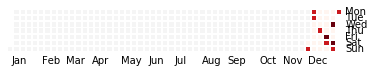

In [16]:
import calmap
import matplotlib.pyplot as plt

fig, cal_ax = plt.subplots()

windyDaysPD = windyDaysDF.select("Date","pseudoWindSpeedMPH").toPandas()
windyDaysEventsPD = windyDaysPD.set_index(pd.DatetimeIndex(windyDaysPD['Date']))['pseudoWindSpeedMPH']
#windyDaysPD.dtypes

#windyDaysEventsPD.dtype

#windyDaysEventsPD.dtypes
#windyDaysEventsPD.dtypes
calmap.yearplot(windyDaysEventsPD, ax=cal_ax, year=2012)
#windyDaysEventsPD

#events = pd.Series(windyDaysPD['pseudoWindSpeedMPH'], index=windyDaysPD['Date'])
#events
#fig